
# Pre-Processing of Data


# Setting data up


Factorization


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

class MovieLensAnalyzer:
    @staticmethod
    def plot_rating_distribution(ratings_df):
        """Plot the distribution of ratings"""
        plt.figure(figsize=(15, 5))

        # Plot 1: Rating Distribution
        plt.subplot(1, 2, 1)
        sns.histplot(data=ratings_df, x='rating', bins=10)
        plt.title('Distribution of Ratings')
        plt.xlabel('Rating')
        plt.ylabel('Count')

        # Plot 2: Ratings per User
        plt.subplot(1, 2, 2)
        user_ratings_count = ratings_df['userId'].value_counts()
        sns.histplot(data=user_ratings_count, bins=50)
        plt.title('Ratings per User')
        plt.xlabel('Number of Ratings')
        plt.ylabel('Number of Users')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nRatings Summary Statistics:")
        print(ratings_df['rating'].describe())

        print("\nUser Activity Summary Statistics:")
        print(user_ratings_count.describe())

    @staticmethod
    def plot_rating_heatmap(ratings_df, max_users=100, max_movies=100):
        """Plot a heatmap of user-movie ratings"""
        # Sample users and movies for visualization
        users = ratings_df['userId'].value_counts()[:max_users].index
        movies = ratings_df['movieId'].value_counts()[:max_movies].index

        # Create a pivot table
        rating_matrix = ratings_df[
            ratings_df['userId'].isin(users) &
            ratings_df['movieId'].isin(movies)
        ].pivot(index='userId', columns='movieId', values='rating')

        plt.figure(figsize=(10, 8))
        sns.heatmap(rating_matrix, cmap='YlOrRd', cbar_kws={'label': 'Rating'})
        plt.title('User-Movie Rating Heatmap (Sample)')
        plt.xlabel('Movie ID')
        plt.ylabel('User ID')
        plt.show()

class MemoryEfficientPreprocessor:
    def prepare_data(self, ratings_df, movies_df=None, min_ratings=50, sample_size=None):
        """
        Prepare the data with optional sampling for memory efficiency

        Parameters:
        ratings_df (DataFrame): Original ratings dataframe
        movies_df (DataFrame): Movies dataframe (optional)
        min_ratings (int): Minimum number of ratings for a movie
        sample_size (int): Number of users to sample (None for all users)
        """
        print("Initial dataset statistics:")
        print(f"Number of ratings: {len(ratings_df)}")
        print(f"Number of unique users: {ratings_df['userId'].nunique()}")
        print(f"Number of unique movies: {ratings_df['movieId'].nunique()}")

        # Analyze initial rating distribution
        print("\nAnalyzing initial rating distribution...")
        MovieLensAnalyzer.plot_rating_distribution(ratings_df)

        print("\nFiltering movies...")
        movie_counts = ratings_df['movieId'].value_counts()
        popular_movies = movie_counts[movie_counts >= min_ratings].index

        filtered_ratings = ratings_df[ratings_df['movieId'].isin(popular_movies)].copy()

        if sample_size is not None:
            print(f"\nSampling {sample_size} users...")
            unique_users = filtered_ratings['userId'].unique()
            if len(unique_users) > sample_size:
                sampled_users = np.random.choice(unique_users, sample_size, replace=False)
                filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(sampled_users)]

        # Create efficient mappings
        print("\nCreating user and movie mappings...")
        user_ids = filtered_ratings['userId'].unique()
        movie_ids = filtered_ratings['movieId'].unique()

        user_to_idx = {id: idx for idx, id in enumerate(user_ids)}
        movie_to_idx = {id: idx for idx, id in enumerate(movie_ids)}

        # Convert IDs to indices
        filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_to_idx)
        filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_to_idx)

        print(f"\nDataset statistics after preprocessing:")
        print(f"Number of users: {len(user_ids)}")
        print(f"Number of movies: {len(movie_ids)}")
        print(f"Number of ratings: {len(filtered_ratings)}")
        print(f"Sparsity: {(1 - len(filtered_ratings)/(len(user_ids)*len(movie_ids)))*100:.2f}%")

        # Plot processed rating distribution
        print("\nAnalyzing processed rating distribution...")
        MovieLensAnalyzer.plot_rating_distribution(filtered_ratings)

        # Plot rating heatmap
        print("\nGenerating rating heatmap (sample)...")
        MovieLensAnalyzer.plot_rating_heatmap(filtered_ratings)

        if movies_df is not None:
            filtered_movies = movies_df[movies_df['movieId'].isin(movie_ids)]
            print("\nMovie genre distribution:")
            genres = filtered_movies['genres'].str.split('|', expand=True).stack()
            print(genres.value_counts().head(10))

        return filtered_ratings, user_to_idx, movie_to_idx

class MemoryEfficientRecommender:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
        self.user_to_idx = None
        self.movie_to_idx = None
        self.idx_to_movie = None

    def create_sparse_matrix(self, ratings_df, n_users, n_movies):
        """Create a sparse rating matrix"""
        rows = ratings_df['user_idx'].values
        cols = ratings_df['movie_idx'].values
        values = ratings_df['rating'].values
        return csr_matrix((values, (rows, cols)), shape=(n_users, n_movies))

    def fit(self, ratings_df, n_users, n_movies, user_to_idx, movie_to_idx):
        """Fit the model using sparse matrices"""
        print("Creating sparse matrix...")
        start_time = time.time()

        # Store mappings
        self.user_to_idx = user_to_idx
        self.movie_to_idx = movie_to_idx
        self.idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

        sparse_matrix = self.create_sparse_matrix(ratings_df, n_users, n_movies)
        self.global_mean = ratings_df['rating'].mean()

        print(f"Matrix creation took {time.time() - start_time:.2f} seconds")
        print(f"Matrix shape: {sparse_matrix.shape}")
        print("Starting SVD...")

        U, sigma, Vt = svds(sparse_matrix, k=self.n_factors)

        self.user_factors = U
        self.item_factors = np.diag(sigma).dot(Vt)

        print("SVD completed!")
        return self

    def predict(self, user_indices, movie_indices):
        """Predict ratings for given user-movie pairs"""
        if not isinstance(user_indices, np.ndarray):
            user_indices = np.array(user_indices)
        if not isinstance(movie_indices, np.ndarray):
            movie_indices = np.array(movie_indices)

        predictions = np.sum(
            self.user_factors[user_indices] * self.item_factors[:, movie_indices].T,
            axis=1
        )
        return predictions + self.global_mean

    def evaluate(self, test_df):
        """Evaluate the model using RMSE and MAE"""
        user_indices = test_df['user_idx'].values
        movie_indices = test_df['movie_idx'].values
        actual_ratings = test_df['rating'].values

        # Get predictions
        predicted_ratings = self.predict(user_indices, movie_indices)

        # Calculate RMSE
        rmse = np.sqrt(np.mean((actual_ratings - predicted_ratings) ** 2))

        # Calculate MAE
        mae = np.mean(np.abs(actual_ratings - predicted_ratings))

        return rmse, mae

    def get_recommendations(self, user_id, movies_df, ratings_df, n_recommendations=10):
        """Get movie recommendations for a specific user"""
        if user_id not in self.user_to_idx:
            raise ValueError(f"User ID {user_id} not found in training data")

        user_idx = self.user_to_idx[user_id]

        # Get all available movie indices
        available_movie_indices = np.array(list(self.movie_to_idx.values()))

        # Get predictions
        predictions = self.predict([user_idx] * len(available_movie_indices),
                                 available_movie_indices)

        # Create recommendations DataFrame
        recommendations = pd.DataFrame({
            'movieId': [self.idx_to_movie[idx] for idx in available_movie_indices],
            'predicted_rating': predictions
        })

        # Merge with movie information
        recommendations = recommendations.merge(
            movies_df[['movieId', 'title', 'genres']],
            on='movieId',
            how='inner'
        )

        # Filter out rated movies
        rated_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
        recommendations = recommendations[~recommendations['movieId'].isin(rated_movies)]

        # Sort and return top N
        return recommendations.sort_values('predicted_rating', ascending=False).head(n_recommendations)


def demonstrate_recommendations(model, user_id, movies_df, ratings_df, n_recommendations=10):
    """
    Demonstrate the recommendation system for a user

    Parameters:
    model: MemoryEfficientRecommender instance
    user_id: Original user ID
    movies_df: DataFrame containing movie information
    ratings_df: DataFrame containing ratings
    n_recommendations: Number of recommendations to show

    Returns:
    DataFrame containing the recommendations
    """
    try:
        # Get user's actual ratings
        user_ratings = ratings_df[ratings_df['userId'] == user_id].merge(
            movies_df[['movieId', 'title', 'genres']],
            on='movieId'
        )

        print(f"\nUser {user_id}'s Rating History:")
        if len(user_ratings) > 0:
            print("\nTop 5 Rated Movies:")
            print(user_ratings[['title', 'rating', 'genres']]
                  .sort_values('rating', ascending=False)
                  .head()
                  .to_string(index=False))

            print(f"\nTotal movies rated by user: {len(user_ratings)}")
            print(f"Average rating given: {user_ratings['rating'].mean():.2f}")
        else:
            print("No rating history found for this user in the filtered dataset.")

        # Get recommendations
        recommendations = model.get_recommendations(user_id, movies_df, ratings_df, n_recommendations)

        print(f"\nTop {n_recommendations} Recommendations:")
        for _, row in recommendations.iterrows():
            print("\n" + "-" * 50)
            print(f"Movie: {row['title']}")
            print(f"Predicted Rating: {row['predicted_rating']:.2f}")
            print(f"Genres: {row['genres']}")

        return recommendations

    except ValueError as e:
        print(f"Error: {str(e)}")
        print("Please choose a user ID that exists in the filtered dataset.")
        return None



# Running and Recommendation

Setting up Google Colab environment...
Mounted at /content/drive

Initializing recommender system...
Loading data...
Initial dataset statistics:
Number of ratings: 20000263
Number of unique users: 138493
Number of unique movies: 26744

Analyzing initial rating distribution...


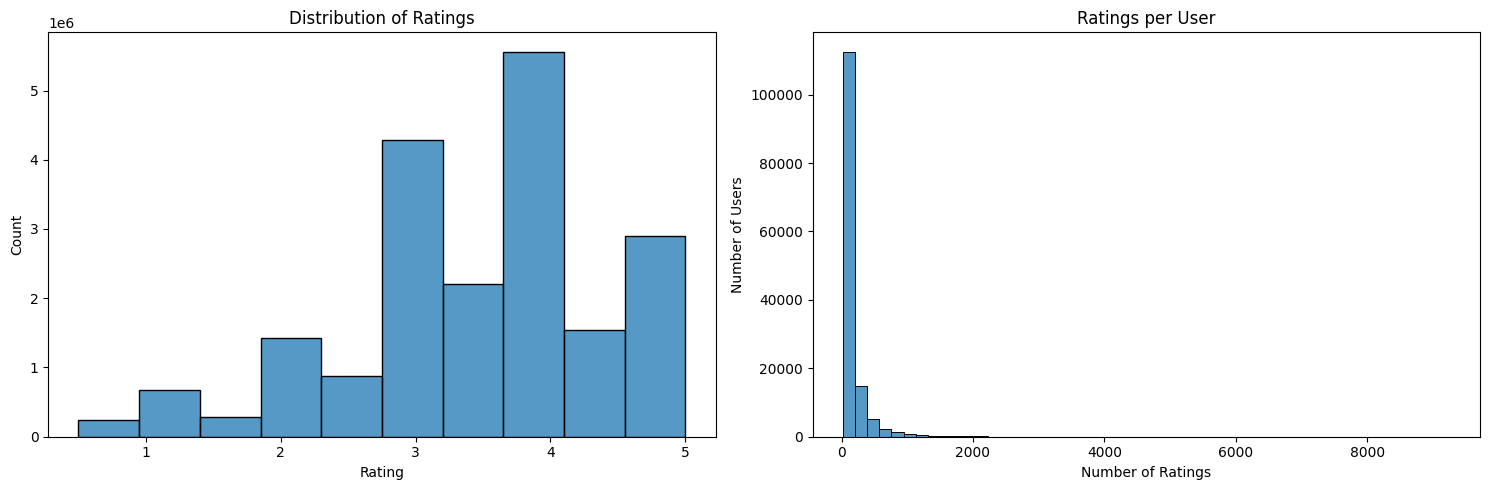


Ratings Summary Statistics:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: count, dtype: float64

Filtering movies...

Sampling 10000 users...

Creating user and movie mappings...

Dataset statistics after preprocessing:
Number of users: 10000
Number of movies: 10502
Number of ratings: 1393937
Sparsity: 98.67%

Analyzing processed rating distribution...


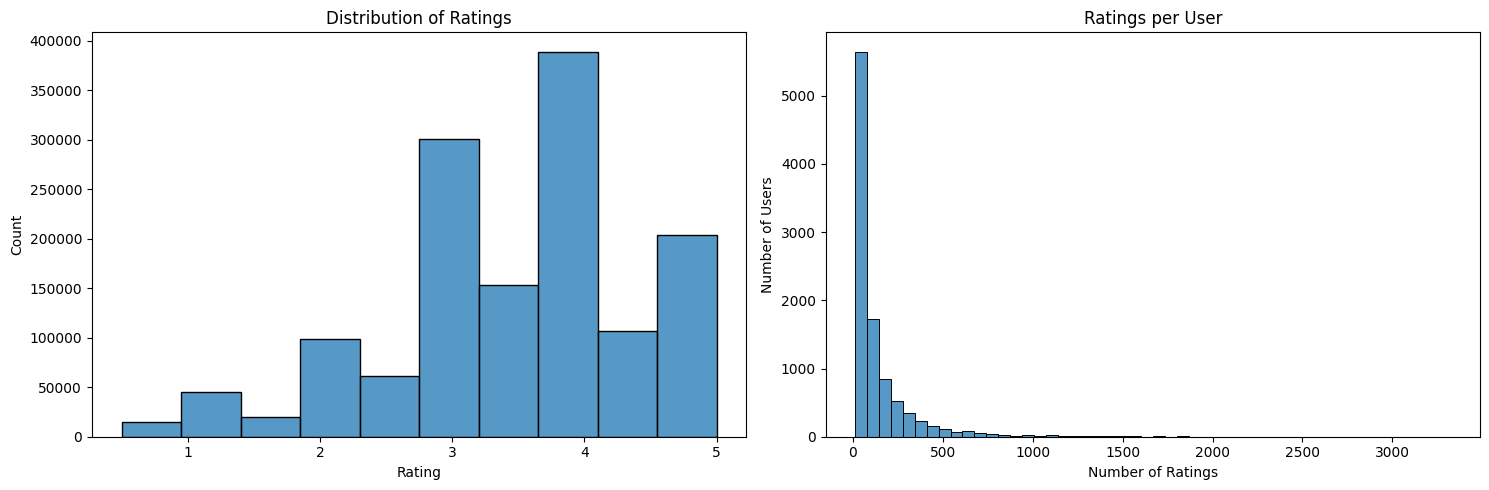


Ratings Summary Statistics:
count    1.393937e+06
mean     3.535796e+00
std      1.042611e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    10000.000000
mean       139.393700
std        211.480928
min         14.000000
25%         34.000000
50%         66.000000
75%        155.000000
max       3322.000000
Name: count, dtype: float64

Generating rating heatmap (sample)...


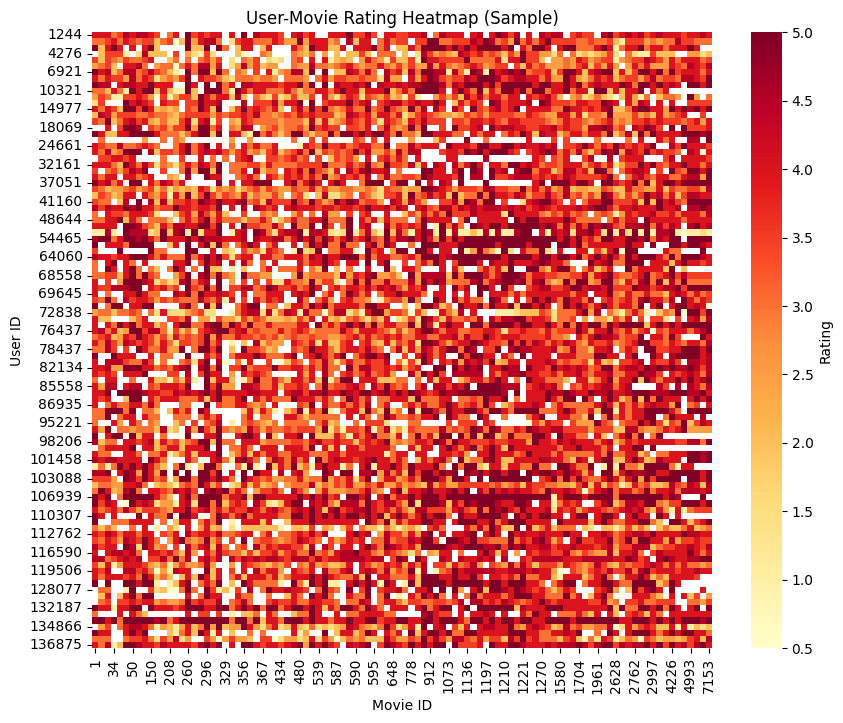


Movie genre distribution:
Drama        5148
Comedy       3767
Thriller     1994
Romance      1799
Action       1715
Crime        1276
Adventure    1187
Horror       1035
Sci-Fi        900
Fantasy       705
Name: count, dtype: int64

Splitting data...

Training model...
Creating sparse matrix...
Matrix creation took 0.07 seconds
Matrix shape: (10000, 10502)
Starting SVD...
SVD completed!

Evaluating model...
Test RMSE: 1.5479
Test MAE: 1.2318

Generating sample recommendations...

User 6055's Rating History:

Top 5 Rated Movies:
                                                    title  rating            genres
                                    Apocalypse Now (1979)     5.0  Action|Drama|War
                                           Amadeus (1984)     5.0             Drama
Lord of the Rings: The Fellowship of the Ring, The (2001)     5.0 Adventure|Fantasy
                             M*A*S*H (a.k.a. MASH) (1970)     5.0  Comedy|Drama|War
                                       Sling 

In [ ]:
def setup_colab_paths():
    """Setup Google Colab environment and return data paths"""
    from google.colab import drive
    import os

    # Mount Google Drive
    drive.mount('/content/drive')

    # Set up base paths
    prefix = '/content/drive/My Drive/'
    notebooks_path = 'Colab Notebooks/'  # Adjust this if your folder structure is different
    sys_path = prefix + notebooks_path

    # Add to Python path
    import sys
    if sys_path not in sys.path:
        sys.path.append(sys_path)

    # Construct file paths
    ratings_path = os.path.join(sys_path, 'rating.csv')
    movies_path = os.path.join(sys_path, 'movie.csv')

    # Verify files exist
    if not os.path.exists(ratings_path):
        raise FileNotFoundError(f"Ratings file not found at {ratings_path}")
    if not os.path.exists(movies_path):
        raise FileNotFoundError(f"Movies file not found at {movies_path}")

    return ratings_path, movies_path



def run_efficient_recommender(ratings_path, movies_path=None, sample_size=10000):
    """Run the complete recommendation pipeline"""
    # 1. Load data
    print("Loading data...")
    ratings_df = pd.read_csv(ratings_path)
    movies_df = pd.read_csv(movies_path) if movies_path else None

    # 2. Preprocess data
    preprocessor = MemoryEfficientPreprocessor()
    filtered_ratings, user_to_idx, movie_to_idx = preprocessor.prepare_data(
        ratings_df,
        movies_df,
        min_ratings=50,
        sample_size=sample_size
    )

    # Filter movies_df to only include movies in filtered_ratings
    filtered_movies = movies_df[movies_df['movieId'].isin(filtered_ratings['movieId'].unique())]

    # 3. Split data
    print("\nSplitting data...")
    train_df, test_df = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

    # 4. Train model
    print("\nTraining model...")
    model = MemoryEfficientRecommender(n_factors=50)
    model.fit(
        train_df,
        n_users=len(user_to_idx),
        n_movies=len(movie_to_idx),
        user_to_idx=user_to_idx,
        movie_to_idx=movie_to_idx
    )

    # 5. Evaluate
    print("\nEvaluating model...")
    rmse, mae = model.evaluate(test_df)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")

    return model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx

def main():
    """Main function to run the recommender system"""
    try:
        # Setup paths for Google Colab
        print("Setting up Google Colab environment...")
        ratings_path, movies_path = setup_colab_paths()

        # Run the recommender system
        print("\nInitializing recommender system...")
        model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = run_efficient_recommender(
            ratings_path,
            movies_path,
            sample_size=10000
        )

        return model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise  # Re-raise the exception instead of returning None

# Run the complete system
if __name__ == "__main__":
    try:
        model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = main()

        # Show some sample recommendations
        print("\nGenerating sample recommendations...")
        sample_user_id = np.random.choice(filtered_ratings['userId'].unique())
        recommendations = demonstrate_recommendations(
            model,
            sample_user_id,
            filtered_movies,
            filtered_ratings,
            n_recommendations=5
        )
    except Exception as e:
        print(f"Error running the recommender system: {str(e)}")


# Weeks 5-6: Content Based Filtering and Hybrid Models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sparse

class ContentBasedRecommender:
    def __init__(self):
        self.movie_features = None
        self.movie_ids = None
        self.genre_matrix = None

    def _create_genre_matrix(self, movies_df):
        """Convert genres into a binary matrix"""
        # Split genres and create binary columns
        genre_matrix = movies_df['genres'].str.get_dummies(sep='|')
        return genre_matrix

    def fit(self, movies_df):
        """
        Build the content-based features from movie metadata

        Parameters:
        movies_df: DataFrame containing movieId, title, and genres
        """
        print("Creating genre features...")
        self.genre_matrix = self._create_genre_matrix(movies_df)
        self.movie_ids = movies_df['movieId'].values

        # Store movies dataframe for later use
        self.movies_df = movies_df

        print(f"Created features for {len(self.movie_ids)} movies")
        print(f"Genre features: {self.genre_matrix.columns.tolist()}")
        return self

    def get_similar_movies(self, movie_id, n_similar=5):
        """Get similar movies based on genre similarity"""
        try:
            # Find the index of the movie
            movie_idx = self.movies_df[self.movies_df['movieId'] == movie_id].index[0]

            # Calculate similarity with all other movies
            movie_features = self.genre_matrix.iloc[movie_idx].values.reshape(1, -1)
            similarities = cosine_similarity(movie_features, self.genre_matrix)

            # Get indices of most similar movies
            similar_indices = similarities[0].argsort()[::-1][1:n_similar+1]

            # Get movie IDs and similarity scores
            similar_movies = self.movies_df.iloc[similar_indices]
            similarity_scores = similarities[0][similar_indices]

            return pd.DataFrame({
                'movieId': similar_movies['movieId'],
                'title': similar_movies['title'],
                'genres': similar_movies['genres'],
                'similarity': similarity_scores
            })

        except IndexError:
            print(f"Movie ID {movie_id} not found in the dataset")
            return pd.DataFrame()

class HybridRecommender:
    def __init__(self, cf_weight=0.7):
        """
        Initialize hybrid recommender

        Parameters:
        cf_weight: Weight given to collaborative filtering recommendations (0-1)
        """
        self.cf_recommender = None  # Collaborative filtering model
        self.cb_recommender = None  # Content-based model
        self.cf_weight = cf_weight
        self.cb_weight = 1 - cf_weight

    def fit(self, ratings_df, movies_df, n_factors=50):
        """Train both recommender systems"""
        # Train collaborative filtering
        print("Training collaborative filtering model...")
        self.cf_recommender = MemoryEfficientRecommender(n_factors=n_factors)
        self.cf_recommender.fit(
            ratings_df,
            len(ratings_df['userId'].unique()),
            len(ratings_df['movieId'].unique()),
            {id: idx for idx, id in enumerate(ratings_df['userId'].unique())},
            {id: idx for idx, id in enumerate(ratings_df['movieId'].unique())}
        )

        # Train content-based filtering
        print("Training content-based model...")
        self.cb_recommender = ContentBasedRecommender()
        self.cb_recommender.fit(movies_df)

        return self

    def get_recommendations(self, user_id, movies_df, ratings_df, n_recommendations=10):
        """Get hybrid recommendations for a user"""
        try:
            # Get collaborative filtering recommendations
            cf_recs = self.cf_recommender.get_recommendations(
                user_id,
                movies_df,
                ratings_df,
                n_recommendations=n_recommendations*2  # Get extra recommendations to combine
            )

            # Get user's highest rated movie
            user_ratings = ratings_df[ratings_df['userId'] == user_id]
            if len(user_ratings) > 0:
                top_movie = user_ratings.sort_values('rating', ascending=False).iloc[0]

                # Get content-based recommendations based on user's top rated movie
                cb_recs = self.cb_recommender.get_similar_movies(
                    top_movie['movieId'],
                    n_similar=n_recommendations*2
                )

                # Combine recommendations
                cf_recs['cf_score'] = (cf_recs['predicted_rating'] - cf_recs['predicted_rating'].min()) / \
                                    (cf_recs['predicted_rating'].max() - cf_recs['predicted_rating'].min())

                # Merge recommendations
                hybrid_recs = cf_recs.merge(cb_recs[['movieId', 'similarity']],
                                          on='movieId',
                                          how='left')
                hybrid_recs['similarity'] = hybrid_recs['similarity'].fillna(0)

                # Calculate hybrid score
                hybrid_recs['hybrid_score'] = (self.cf_weight * hybrid_recs['cf_score'] +
                                             self.cb_weight * hybrid_recs['similarity'])

                # Sort and return top recommendations
                return hybrid_recs.sort_values('hybrid_score', ascending=False).head(n_recommendations)

            else:
                # If no ratings, return only content-based recommendations
                return cf_recs.head(n_recommendations)

        except Exception as e:
            print(f"Error generating recommendations: {str(e)}")
            return pd.DataFrame()

# Function to demonstrate the hybrid recommender
def demonstrate_hybrid_recommendations(hybrid_model, user_id, movies_df, ratings_df, n_recommendations=5):
    """Show recommendations from both systems and hybrid approach"""
    print(f"\nGenerating recommendations for user {user_id}")

    # Get user's rating history
    user_ratings = ratings_df[ratings_df['userId'] == user_id].merge(
        movies_df[['movieId', 'title', 'genres']],
        on='movieId'
    )

    print("\nUser's rating history:")
    print(user_ratings[['title', 'rating', 'genres']]
          .sort_values('rating', ascending=False)
          .head()
          .to_string(index=False))

    # Get hybrid recommendations
    recommendations = hybrid_model.get_recommendations(
        user_id,
        movies_df,
        ratings_df,
        n_recommendations=n_recommendations
    )

    print(f"\nTop {n_recommendations} Hybrid Recommendations:")
    for _, row in recommendations.iterrows():
        print(f"\nMovie: {row['title']}")
        print(f"Genres: {row['genres']}")
        print(f"Hybrid Score: {row['hybrid_score']:.3f}")
        print(f"CF Score: {row['cf_score']:.3f}")
        print(f"Content Similarity: {row['similarity']:.3f}")
        print("-" * 50)

    return recommendations

In [ ]:
# Initialize and train the hybrid recommender
hybrid_recommender = HybridRecommender(cf_weight=0.7)  # 70% CF, 30% content-based
hybrid_recommender.fit(filtered_ratings, filtered_movies)

# Generate recommendations for a user
user_id = filtered_ratings['userId'].iloc[0]  # Example user
recommendations = demonstrate_hybrid_recommendations(
    hybrid_recommender,
    user_id,
    filtered_movies,
    filtered_ratings,
    n_recommendations=5
)

Training collaborative filtering model...
Creating sparse matrix...
Matrix creation took 0.09 seconds
Matrix shape: (10000, 10502)
Starting SVD...
SVD completed!
Training content-based model...
Creating genre features...
Created features for 10502 movies
Genre features: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Generating recommendations for user 16

User's rating history:
                     title  rating                                  genres
              Ghost (1990)     5.0   Comedy|Drama|Fantasy|Romance|Thriller
      Roman Holiday (1953)     5.0                    Comedy|Drama|Romance
          Threesome (1994)     5.0                          Comedy|Romance
Princess Bride, The (1987)     5.0 Action|Adventure|Comedy|Fantasy|Romance
             Grease (1978)     5.0                  Comedy|Musical|Romance

Top 5 H

# Evaluation of Models


Setting up Google Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Initializing recommender system...
Loading data...
Initial dataset statistics:
Number of ratings: 20000263
Number of unique users: 138493
Number of unique movies: 26744

Analyzing initial rating distribution...


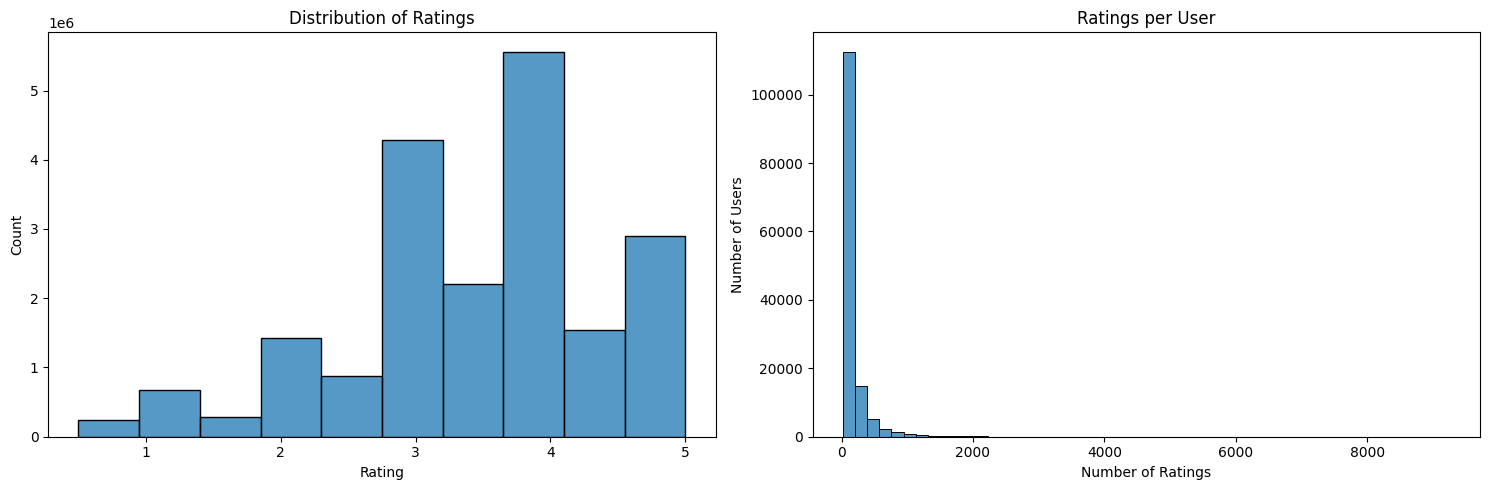


Ratings Summary Statistics:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: count, dtype: float64

Filtering movies...

Sampling 10000 users...

Creating user and movie mappings...

Dataset statistics after preprocessing:
Number of users: 10000
Number of movies: 10508
Number of ratings: 1425956
Sparsity: 98.64%

Analyzing processed rating distribution...


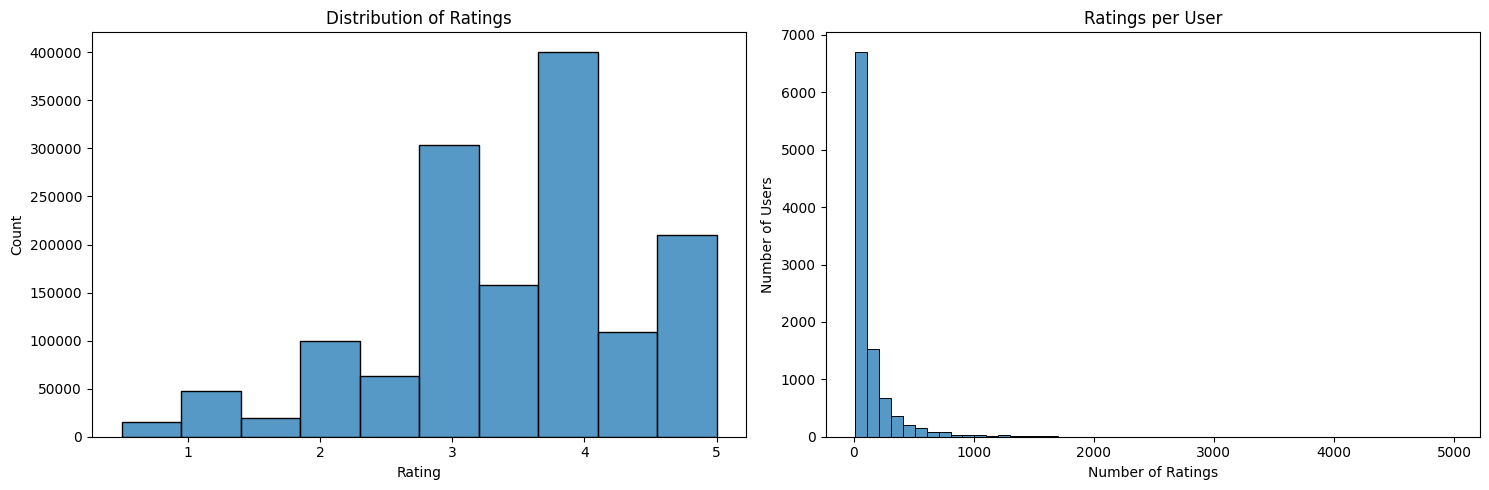


Ratings Summary Statistics:
count    1.425956e+06
mean     3.538705e+00
std      1.045492e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    10000.000000
mean       142.595600
std        222.060256
min         15.000000
25%         35.000000
50%         68.000000
75%        152.000000
max       4968.000000
Name: count, dtype: float64

Generating rating heatmap (sample)...


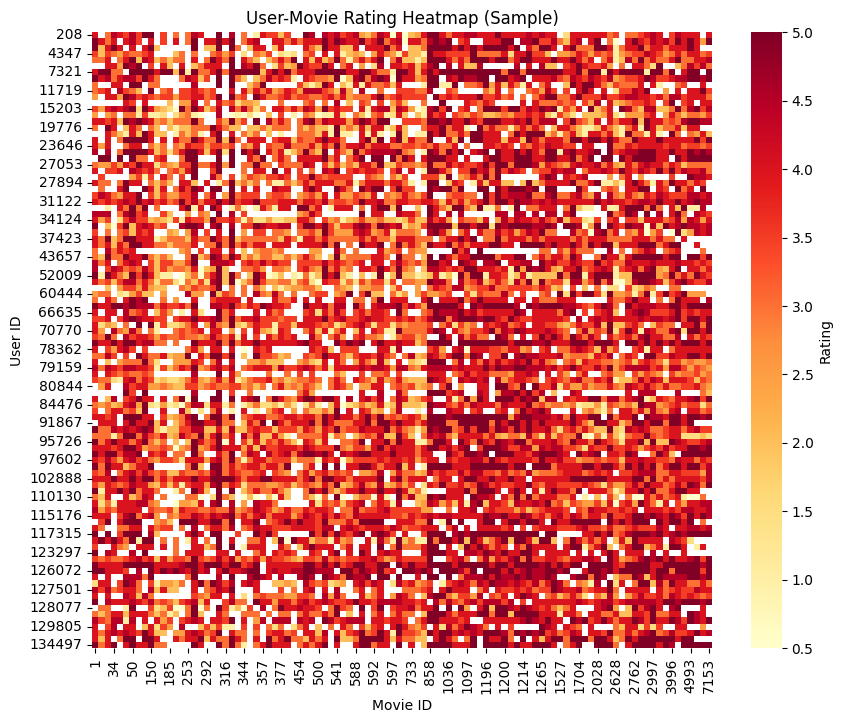


Movie genre distribution:
Drama        5151
Comedy       3768
Thriller     1993
Romance      1800
Action       1719
Crime        1277
Adventure    1189
Horror       1036
Sci-Fi        899
Fantasy       706
Name: count, dtype: int64

Splitting data...

Training model...
Creating sparse matrix...
Matrix creation took 0.08 seconds
Matrix shape: (10000, 10508)
Starting SVD...
SVD completed!

Evaluating model...
Test RMSE: 1.5533
Test MAE: 1.2364

Evaluating Recommender System Performance...

Performance Metrics:
RMSE: 1.5533
MAE: 1.2364
Precision: 0.6153
Recall: 0.9781
F1 Score: 0.7554

Plotting evaluation metrics...


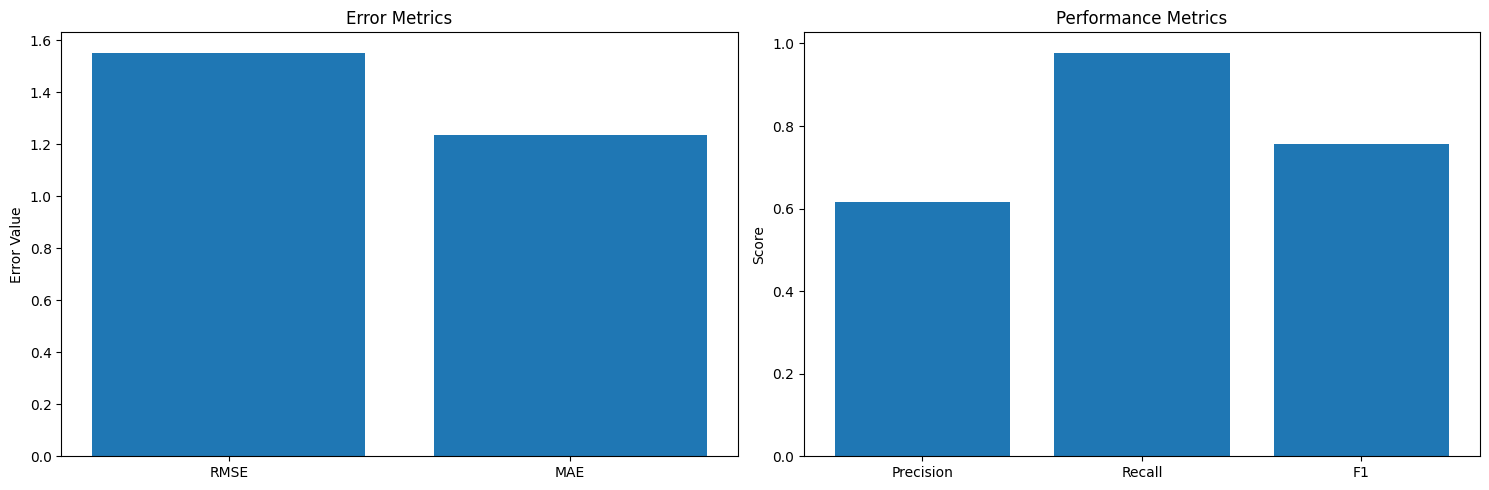


Plotting prediction correlation...


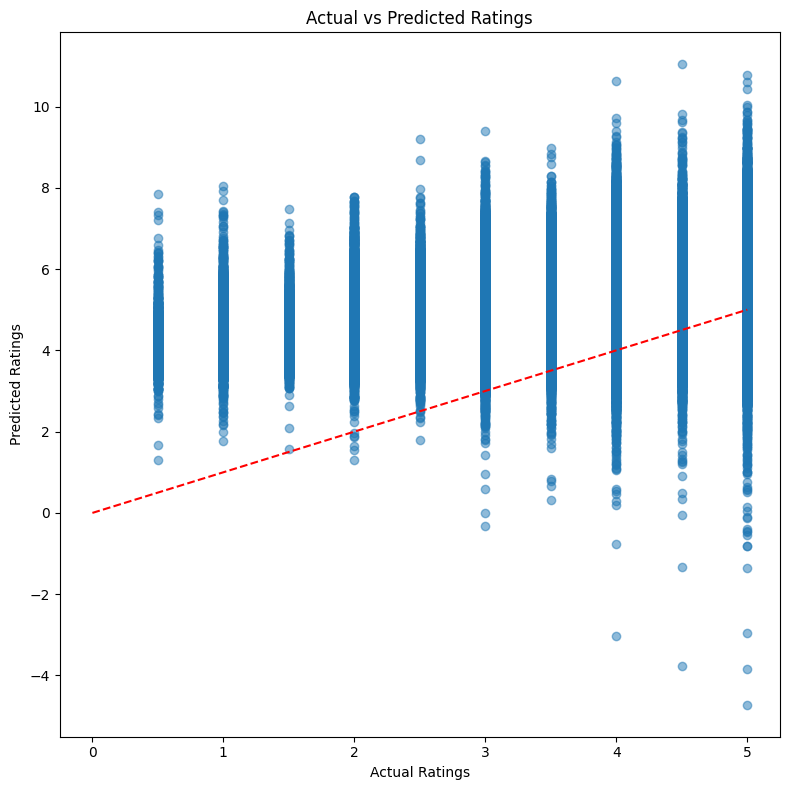


Rating Distribution Analysis:
Actual Ratings - Mean: 3.54, Std: 1.04
Predicted Ratings - Mean: 4.52, Std: 0.89

User 95421's Rating History:

Top 5 Rated Movies:
                                           title  rating                                 genres
                                   Casino (1995)     5.0                            Crime|Drama
     Hobbit: The Desolation of Smaug, The (2013)     5.0                 Adventure|Fantasy|IMAX
   Harry Potter and the Half-Blood Prince (2009)     5.0 Adventure|Fantasy|Mystery|Romance|IMAX
Harry Potter and the Order of the Phoenix (2007)     5.0           Adventure|Drama|Fantasy|IMAX
                           28 Weeks Later (2007)     5.0                 Horror|Sci-Fi|Thriller

Total movies rated by user: 125
Average rating given: 3.63

Top 5 Recommendations:

--------------------------------------------------
Movie: Memento (2000)
Predicted Rating: 5.97
Genres: Mystery|Thriller

--------------------------------------------------
Mov

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

class RecommenderEvaluator:
    @staticmethod
    def calculate_metrics(actual, predicted, threshold=3.5):
        """
        Calculate all evaluation metrics

        Parameters:
        actual: Array of actual ratings
        predicted: Array of predicted ratings
        threshold: Rating threshold to consider an item relevant (default 3.5)
        """
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        # Calculate MAE
        mae = mean_absolute_error(actual, predicted)

        # Convert ratings to binary relevance
        actual_relevant = (actual >= threshold).astype(int)
        predicted_relevant = (predicted >= threshold).astype(int)

        # Calculate Precision and Recall
        precision = precision_score(actual_relevant, predicted_relevant)
        recall = recall_score(actual_relevant, predicted_relevant)

        # Calculate F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'rmse': rmse,
            'mae': mae,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    @staticmethod
    def plot_metrics(metrics_dict):
        """Plot evaluation metrics"""
        plt.figure(figsize=(15, 5))

        # Plot 1: RMSE and MAE
        plt.subplot(1, 2, 1)
        error_metrics = [metrics_dict['rmse'], metrics_dict['mae']]
        plt.bar(['RMSE', 'MAE'], error_metrics)
        plt.title('Error Metrics')
        plt.ylabel('Error Value')

        # Plot 2: Precision, Recall, and F1
        plt.subplot(1, 2, 2)
        performance_metrics = [metrics_dict['precision'], metrics_dict['recall'], metrics_dict['f1']]
        plt.bar(['Precision', 'Recall', 'F1'], performance_metrics)
        plt.title('Performance Metrics')
        plt.ylabel('Score')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_prediction_correlation(actual, predicted):
        """Plot correlation between actual and predicted ratings"""
        plt.figure(figsize=(8, 8))
        plt.scatter(actual, predicted, alpha=0.5)
        plt.plot([0, 5], [0, 5], 'r--')  # Perfect prediction line
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        plt.title('Actual vs Predicted Ratings')
        plt.tight_layout()
        plt.show()

def evaluate_recommender_system(model, test_df, movies_df, ratings_df, threshold=3.5):
    """
    Comprehensive evaluation of the recommender system

    Parameters:
    model: Trained recommender model
    test_df: Test dataset
    movies_df: Movies dataset
    ratings_df: Complete ratings dataset
    threshold: Rating threshold for relevance
    """
    print("\nEvaluating Recommender System Performance...")

    # Get actual and predicted ratings
    actual_ratings = test_df['rating'].values
    predicted_ratings = model.predict(
        test_df['user_idx'].values,
        test_df['movie_idx'].values
    )

    # Calculate metrics
    metrics = RecommenderEvaluator.calculate_metrics(
        actual_ratings,
        predicted_ratings,
        threshold
    )

    # Print metrics
    print("\nPerformance Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    # Plot metrics
    print("\nPlotting evaluation metrics...")
    RecommenderEvaluator.plot_metrics(metrics)

    # Plot prediction correlation
    print("\nPlotting prediction correlation...")
    RecommenderEvaluator.plot_prediction_correlation(actual_ratings, predicted_ratings)

    # Additional analysis
    print("\nRating Distribution Analysis:")
    actual_mean = actual_ratings.mean()
    predicted_mean = predicted_ratings.mean()
    actual_std = actual_ratings.std()
    predicted_std = predicted_ratings.std()

    print(f"Actual Ratings - Mean: {actual_mean:.2f}, Std: {actual_std:.2f}")
    print(f"Predicted Ratings - Mean: {predicted_mean:.2f}, Std: {predicted_std:.2f}")

    return metrics

# Example usage in your main execution:
if __name__ == "__main__":
    try:
        # Get model and data
        model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = main()

        # Split data
        train_df, test_df = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

        # Evaluate system
        metrics = evaluate_recommender_system(
            model,
            test_df,
            filtered_movies,
            filtered_ratings
        )

        # Generate sample recommendations
        sample_user_id = np.random.choice(filtered_ratings['userId'].unique())
        recommendations = demonstrate_recommendations(
            model,
            sample_user_id,
            filtered_movies,
            filtered_ratings,
            n_recommendations=5
        )

    except Exception as e:
        print(f"Error running the evaluation: {str(e)}")

Loading models and data...
Setting up Google Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Initializing recommender system...
Loading data...
Initial dataset statistics:
Number of ratings: 20000263
Number of unique users: 138493
Number of unique movies: 26744

Analyzing initial rating distribution...


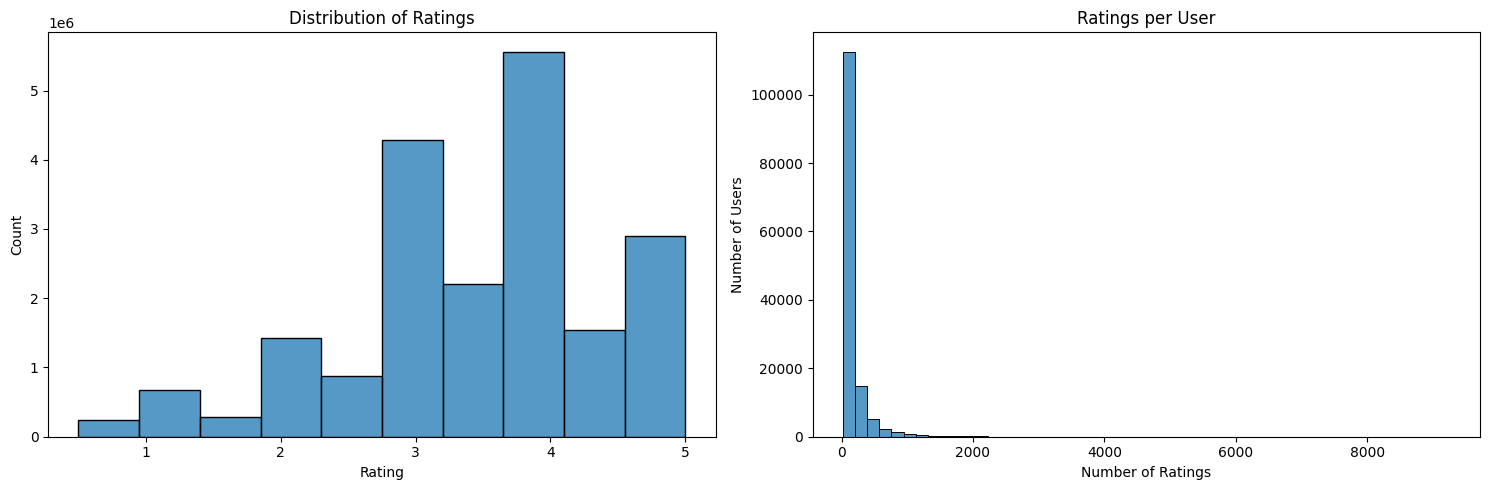


Ratings Summary Statistics:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: count, dtype: float64

Filtering movies...

Sampling 10000 users...

Creating user and movie mappings...

Dataset statistics after preprocessing:
Number of users: 10000
Number of movies: 10507
Number of ratings: 1440663
Sparsity: 98.63%

Analyzing processed rating distribution...


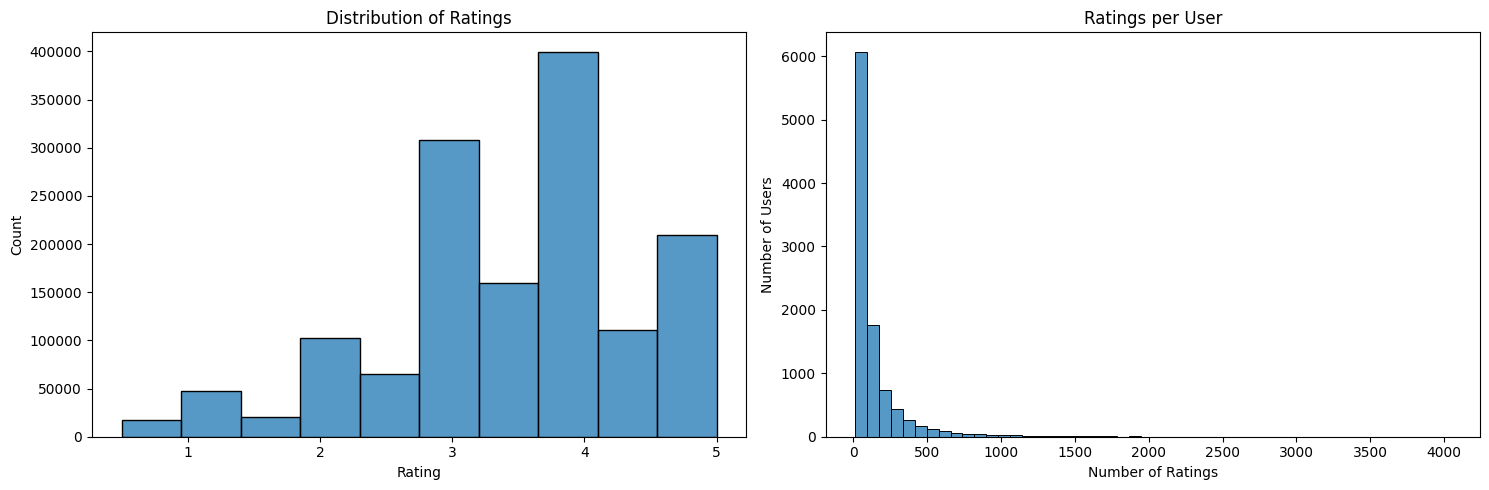


Ratings Summary Statistics:
count    1.440663e+06
mean     3.526740e+00
std      1.049715e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    10000.000000
mean       144.066300
std        223.942288
min         14.000000
25%         35.000000
50%         68.000000
75%        151.000000
max       4041.000000
Name: count, dtype: float64

Generating rating heatmap (sample)...


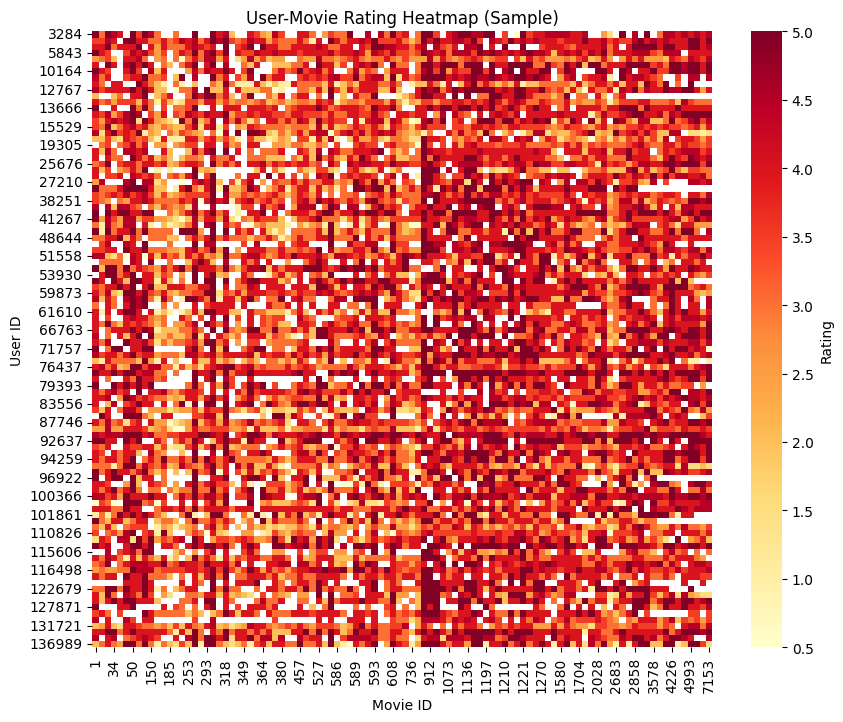


Movie genre distribution:
Drama        5149
Comedy       3766
Thriller     1995
Romance      1798
Action       1717
Crime        1276
Adventure    1187
Horror       1038
Sci-Fi        900
Fantasy       706
Name: count, dtype: int64

Splitting data...

Training model...
Creating sparse matrix...
Matrix creation took 0.07 seconds
Matrix shape: (10000, 10507)
Starting SVD...
SVD completed!

Evaluating model...
Test RMSE: 1.5669
Test MAE: 1.2489

Initializing content-based recommender...
Creating genre features...
Created features for 10507 movies
Genre features: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Generating comparative recommendations...

Comparing Recommendations for User 16553

User's Top Rated Movies:
- Inland Empire (2006) (Rating: 5.0) - Drama|Mystery|Thriller
- Shining, The (1980) (Rating: 5.0) - Horror
- Clockw

In [ ]:
def demonstrate_content_based_recommendations(content_model, movie_id, movies_df, n_recommendations=5):
    """
    Demonstrate the content-based recommender system

    Parameters:
    content_model: ContentBasedRecommender instance
    movie_id: ID of the movie to find similar movies for
    movies_df: DataFrame containing movie information
    n_recommendations: Number of recommendations to show
    """
    try:
        # Get the movie information
        movie_info = movies_df[movies_df['movieId'] == movie_id].iloc[0]
        print(f"\nFinding similar movies to: {movie_info['title']}")
        print(f"Genres: {movie_info['genres']}")

        # Get recommendations
        similar_movies = content_model.get_similar_movies(movie_id, n_similar=n_recommendations)

        print(f"\nTop {n_recommendations} Similar Movies:")
        for _, row in similar_movies.iterrows():
            print("\n" + "-" * 50)
            print(f"Movie: {row['title']}")
            print(f"Genres: {row['genres']}")
            print(f"Similarity Score: {row['similarity']:.3f}")

        return similar_movies

    except IndexError:
        print(f"Error: Movie ID {movie_id} not found in the dataset")
        return None

def compare_recommendations(user_id, cf_model, content_model, movies_df, ratings_df, n_recommendations=5):
    """
    Compare recommendations from both collaborative and content-based approaches

    Parameters:
    user_id: User ID to generate recommendations for
    cf_model: Collaborative filtering model (MemoryEfficientRecommender)
    content_model: Content-based model (ContentBasedRecommender)
    movies_df: DataFrame containing movie information
    ratings_df: DataFrame containing ratings
    n_recommendations: Number of recommendations to show
    """
    print(f"\nComparing Recommendations for User {user_id}")
    print("="*70)

    # Get user's rating history
    user_ratings = ratings_df[ratings_df['userId'] == user_id].merge(
        movies_df[['movieId', 'title', 'genres']],
        on='movieId'
    )

    if len(user_ratings) > 0:
        print("\nUser's Top Rated Movies:")
        top_rated = user_ratings.sort_values('rating', ascending=False).head(3)
        for _, movie in top_rated.iterrows():
            print(f"- {movie['title']} (Rating: {movie['rating']}) - {movie['genres']}")

        # Get collaborative filtering recommendations
        print("\nCollaborative Filtering Recommendations:")
        print("-"*50)
        cf_recs = cf_model.get_recommendations(
            user_id,
            movies_df,
            ratings_df,
            n_recommendations
        )
        for _, rec in cf_recs.iterrows():
            print(f"- {rec['title']} (Predicted: {rec['predicted_rating']:.2f}) - {rec['genres']}")

        # Get content-based recommendations based on user's highest-rated movie
        top_movie_id = top_rated.iloc[0]['movieId']
        print("\nContent-Based Recommendations:")
        print(f"(Based on user's highest-rated movie: {top_rated.iloc[0]['title']})")
        print("-"*50)
        content_recs = content_model.get_similar_movies(
            top_movie_id,
            n_similar=n_recommendations
        )
        for _, rec in content_recs.iterrows():
            print(f"- {rec['title']} (Similarity: {rec['similarity']:.3f}) - {rec['genres']}")

        return cf_recs, content_recs
    else:
        print("No rating history found for this user.")
        return None, None

# Example usage:
if __name__ == "__main__":
    try:
        # Get models and data
        print("Loading models and data...")
        model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = main()

        # Initialize content-based model
        print("\nInitializing content-based recommender...")
        content_model = ContentBasedRecommender()
        content_model.fit(filtered_movies)

        # Compare recommendations for a random user
        print("\nGenerating comparative recommendations...")
        sample_user_id = np.random.choice(filtered_ratings['userId'].unique())
        cf_recs, content_recs = compare_recommendations(
            sample_user_id,
            model,  # collaborative filtering model
            content_model,  # content-based model
            filtered_movies,
            filtered_ratings,
            n_recommendations=5
        )

        # Demonstrate content-based recommendations for a specific movie
        print("\nDemonstrating content-based recommendations for a specific movie...")
        sample_movie_id = filtered_movies['movieId'].iloc[0]
        similar_movies = demonstrate_content_based_recommendations(
            content_model,
            sample_movie_id,
            filtered_movies,
            n_recommendations=5
        )

    except Exception as e:
        print(f"Error running the demonstration: {str(e)}")
        raise

In [ ]:
# # After running your main() function and getting your models:
# model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = main()

# # Initialize content-based model
# content_model = ContentBasedRecommender()
# content_model.fit(filtered_movies)

# # Compare recommendations for a specific user
# user_id = filtered_ratings['userId'].iloc[0]  # Or choose any user ID
# cf_recs, content_recs = compare_recommendations(
#     user_id,
#     model,
#     content_model,
#     filtered_movies,
#     filtered_ratings
# )

Setting up Google Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Initializing recommender system...
Loading data...
Initial dataset statistics:
Number of ratings: 20000263
Number of unique users: 138493
Number of unique movies: 26744

Analyzing initial rating distribution...


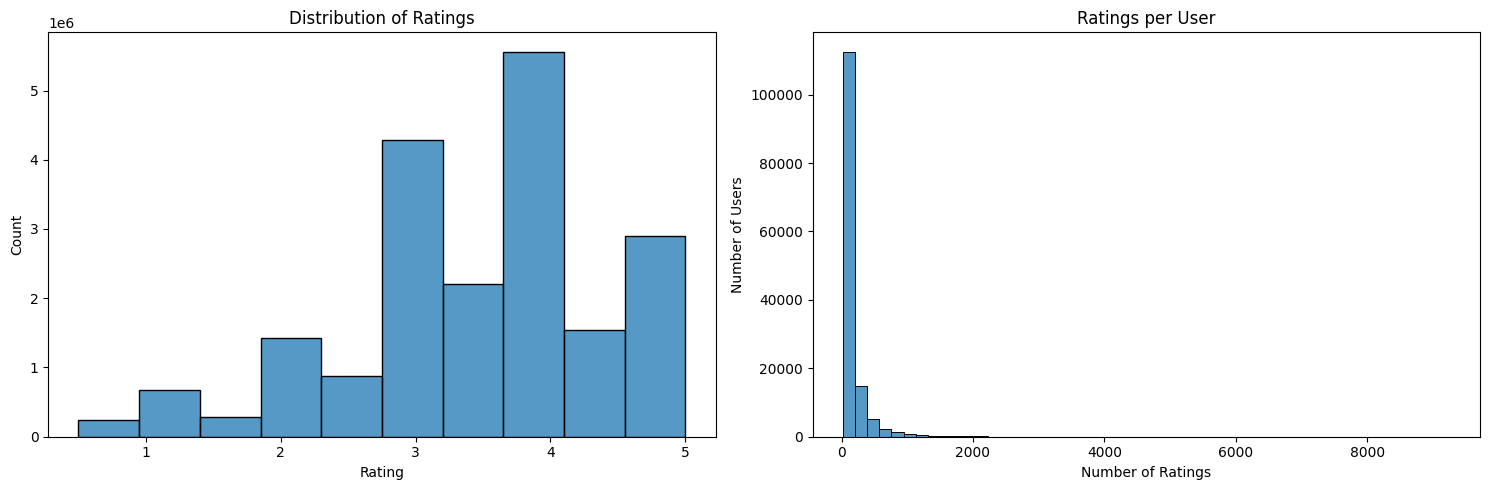


Ratings Summary Statistics:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: count, dtype: float64

Filtering movies...

Sampling 10000 users...

Creating user and movie mappings...

Dataset statistics after preprocessing:
Number of users: 10000
Number of movies: 10518
Number of ratings: 1467029
Sparsity: 98.61%

Analyzing processed rating distribution...


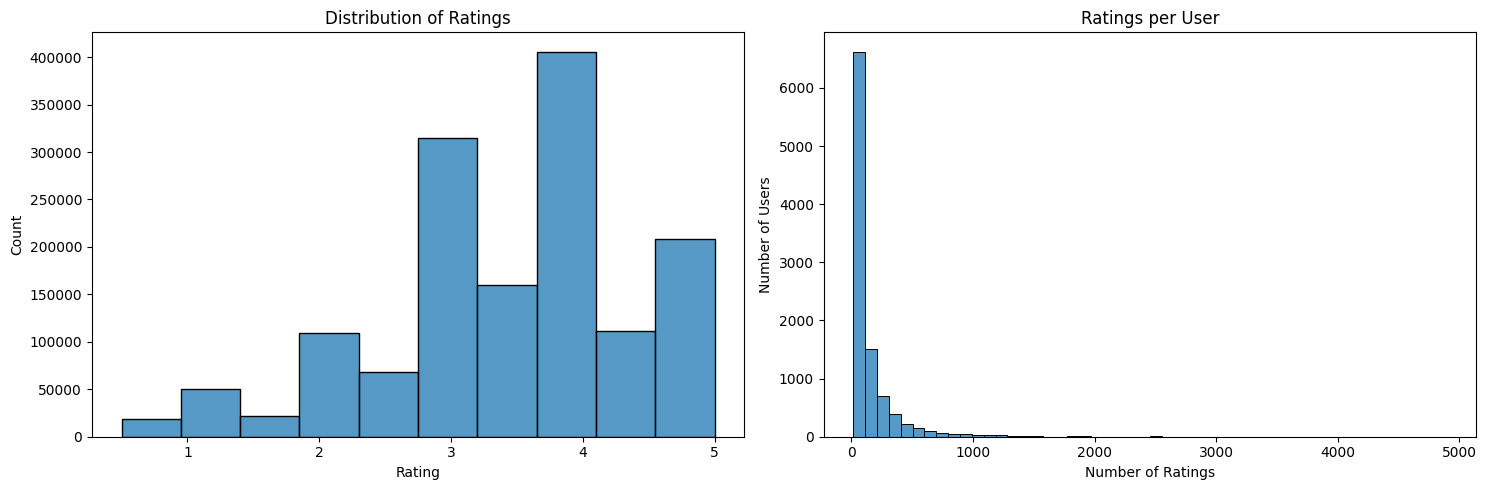


Ratings Summary Statistics:
count    1.467029e+06
mean     3.509295e+00
std      1.057162e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    10000.000000
mean       146.702900
std        227.879781
min         16.000000
25%         35.000000
50%         69.000000
75%        159.000000
max       4893.000000
Name: count, dtype: float64

Generating rating heatmap (sample)...


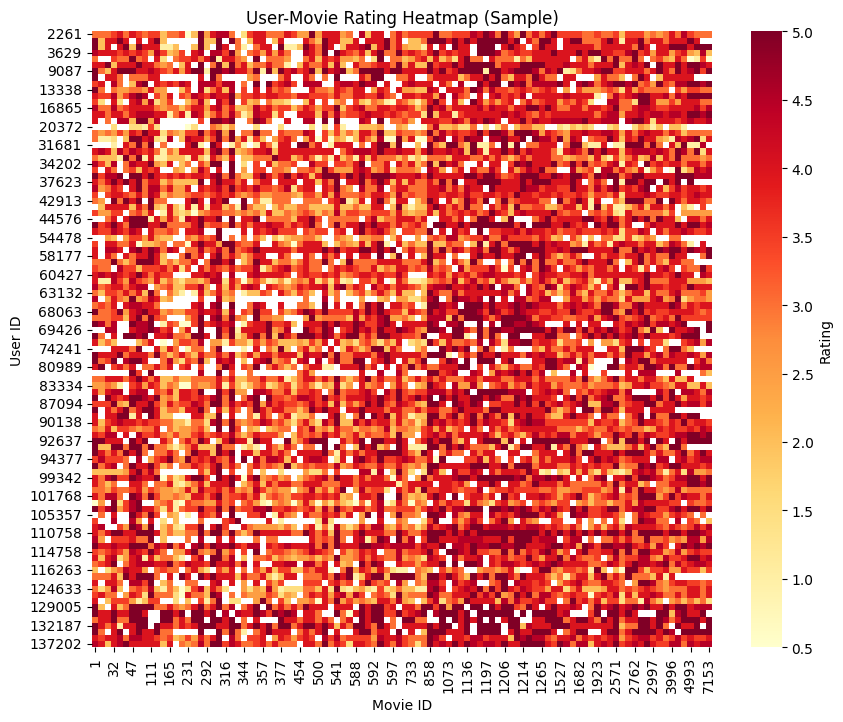


Movie genre distribution:
Drama        5155
Comedy       3770
Thriller     1996
Romance      1801
Action       1720
Crime        1277
Adventure    1189
Horror       1037
Sci-Fi        900
Fantasy       705
Name: count, dtype: int64

Splitting data...

Training model...
Creating sparse matrix...
Matrix creation took 0.08 seconds
Matrix shape: (10000, 10518)
Starting SVD...
SVD completed!

Evaluating model...
Test RMSE: 1.5681
Test MAE: 1.2505
Creating genre features...
Created features for 10518 movies
Genre features: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Evaluating Collaborative Filtering Model...

Evaluating Recommender System Performance...

Performance Metrics:
RMSE: 1.1406
MAE: 0.8865
Precision: 0.6143
Recall: 0.7084
F1 Score: 0.6580

Plotting evaluation metrics...


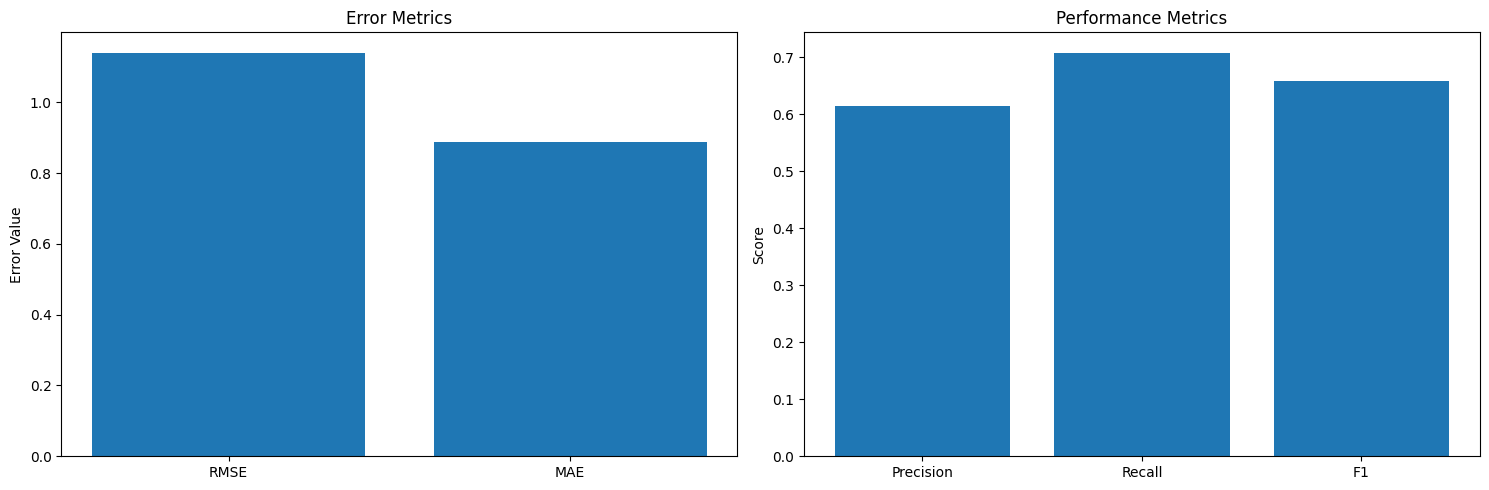


Plotting prediction correlation...


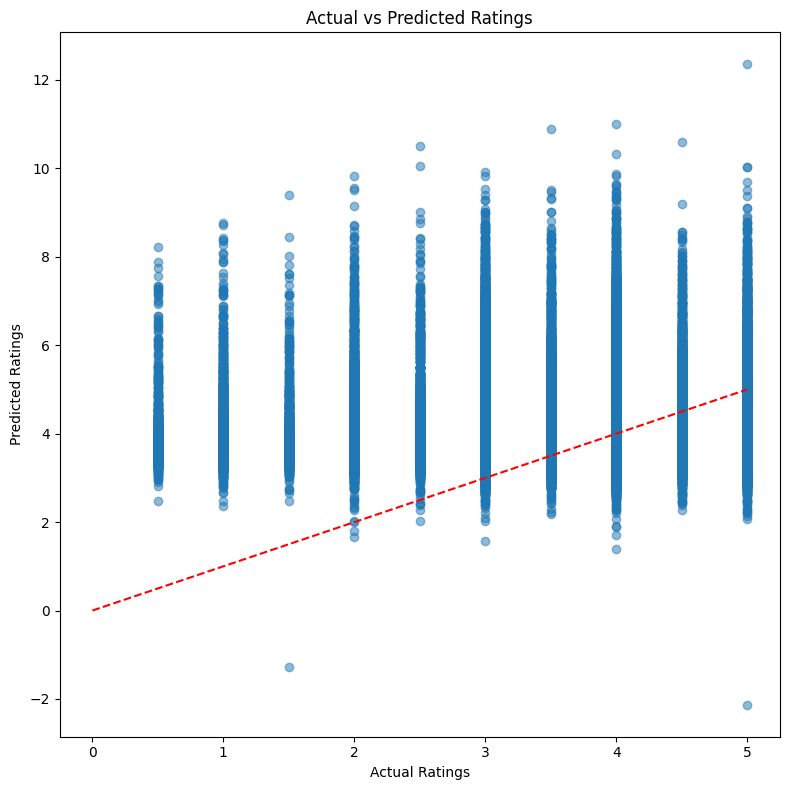


Rating Distribution Analysis:
Actual Ratings - Mean: 3.54, Std: 1.04
Predicted Ratings - Mean: 3.65, Std: 0.47

Evaluating Content-Based Model...

Evaluating Content-Based Recommender Performance...

Content-Based Recommender Metrics:
Average Genre Precision: 0.9627
Average Genre Recall: 0.2086
Average Genre F1 Score: 0.3317
Average Recommendation Diversity: 3.12 genres per recommendation


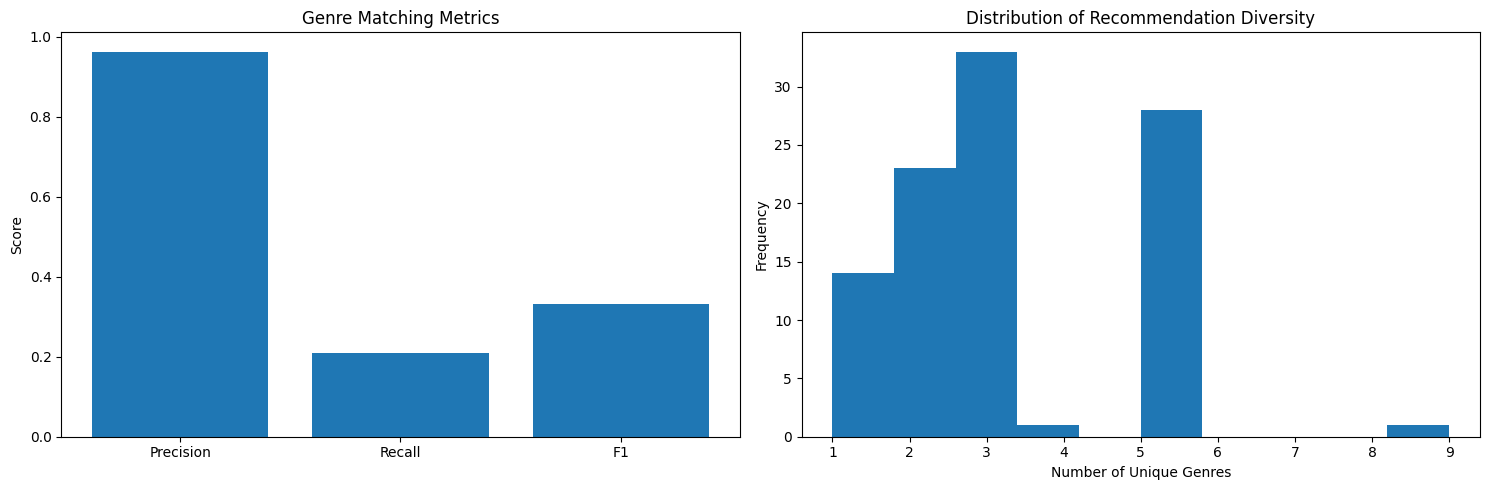

In [ ]:
class ContentBasedEvaluator:
    @staticmethod
    def evaluate_genre_matching(actual_movies, recommended_movies, movies_df):
        """
        Evaluate how well the recommended movies match the genres of movies the user has liked

        Parameters:
        actual_movies: DataFrame of movies the user has rated highly
        recommended_movies: DataFrame of recommended movies
        movies_df: Complete movies DataFrame
        """
        def get_genre_set(movie_genres):
            return set(movie_genres.split('|'))

        # Get genres from actual and recommended movies
        actual_genres = set()
        for genres in actual_movies['genres']:
            actual_genres.update(get_genre_set(genres))

        recommended_genres = set()
        for genres in recommended_movies['genres']:
            recommended_genres.update(get_genre_set(genres))

        # Calculate genre overlap metrics
        genre_overlap = len(actual_genres.intersection(recommended_genres))
        genre_precision = genre_overlap / len(recommended_genres) if recommended_genres else 0
        genre_recall = genre_overlap / len(actual_genres) if actual_genres else 0
        genre_f1 = 2 * (genre_precision * genre_recall) / (genre_precision + genre_recall) if (genre_precision + genre_recall) > 0 else 0

        return {
            'genre_precision': genre_precision,
            'genre_recall': genre_recall,
            'genre_f1': genre_f1,
            'matching_genres': actual_genres.intersection(recommended_genres)
        }

    @staticmethod
    def evaluate_recommendation_diversity(recommended_movies):
        """Evaluate the diversity of recommendations"""
        unique_genres = set()
        for genres in recommended_movies['genres']:
            unique_genres.update(genres.split('|'))

        return {
            'unique_genres': len(unique_genres),
            'genres_list': sorted(list(unique_genres))
        }

def evaluate_content_based_recommender(content_model, test_users, movies_df, ratings_df, n_recommendations=5):
    """
    Comprehensive evaluation of the content-based recommender

    Parameters:
    content_model: Trained ContentBasedRecommender instance
    test_users: List of user IDs to evaluate
    movies_df: Complete movies DataFrame
    ratings_df: Complete ratings DataFrame
    n_recommendations: Number of recommendations to evaluate
    """
    print("\nEvaluating Content-Based Recommender Performance...")

    overall_metrics = {
        'genre_precision': [],
        'genre_recall': [],
        'genre_f1': [],
        'diversity_score': []
    }

    for user_id in test_users:
        # Get user's highly rated movies (rating >= 4)
        user_ratings = ratings_df[
            (ratings_df['userId'] == user_id) &
            (ratings_df['rating'] >= 4)
        ].merge(movies_df[['movieId', 'title', 'genres']], on='movieId')

        if len(user_ratings) > 0:
            # Get top rated movie
            top_movie = user_ratings.iloc[0]

            # Get recommendations based on top movie
            recommendations = content_model.get_similar_movies(
                top_movie['movieId'],
                n_similar=n_recommendations
            )

            # Evaluate genre matching
            genre_metrics = ContentBasedEvaluator.evaluate_genre_matching(
                user_ratings,
                recommendations,
                movies_df
            )

            # Evaluate diversity
            diversity_metrics = ContentBasedEvaluator.evaluate_recommendation_diversity(
                recommendations
            )

            # Store metrics
            overall_metrics['genre_precision'].append(genre_metrics['genre_precision'])
            overall_metrics['genre_recall'].append(genre_metrics['genre_recall'])
            overall_metrics['genre_f1'].append(genre_metrics['genre_f1'])
            overall_metrics['diversity_score'].append(diversity_metrics['unique_genres'])

    # Calculate average metrics
    avg_metrics = {
        'avg_genre_precision': np.mean(overall_metrics['genre_precision']),
        'avg_genre_recall': np.mean(overall_metrics['genre_recall']),
        'avg_genre_f1': np.mean(overall_metrics['genre_f1']),
        'avg_diversity': np.mean(overall_metrics['diversity_score'])
    }

    # Print results
    print("\nContent-Based Recommender Metrics:")
    print(f"Average Genre Precision: {avg_metrics['avg_genre_precision']:.4f}")
    print(f"Average Genre Recall: {avg_metrics['avg_genre_recall']:.4f}")
    print(f"Average Genre F1 Score: {avg_metrics['avg_genre_f1']:.4f}")
    print(f"Average Recommendation Diversity: {avg_metrics['avg_diversity']:.2f} genres per recommendation")

    # Plot metrics
    plt.figure(figsize=(15, 5))

    # Plot 1: Genre matching metrics
    plt.subplot(1, 2, 1)
    genre_scores = [avg_metrics['avg_genre_precision'],
                   avg_metrics['avg_genre_recall'],
                   avg_metrics['avg_genre_f1']]
    plt.bar(['Precision', 'Recall', 'F1'], genre_scores)
    plt.title('Genre Matching Metrics')
    plt.ylabel('Score')

    # Plot 2: Distribution of diversity scores
    plt.subplot(1, 2, 2)
    plt.hist(overall_metrics['diversity_score'], bins=10)
    plt.title('Distribution of Recommendation Diversity')
    plt.xlabel('Number of Unique Genres')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return avg_metrics

# Example usage:
if __name__ == "__main__":
    try:
        # Get your models and data
        model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = main()

        # Initialize and train content-based model
        content_model = ContentBasedRecommender()
        content_model.fit(filtered_movies)

        # Select test users (random sample)
        test_users = np.random.choice(
            filtered_ratings['userId'].unique(),
            size=100,  # Evaluate on 100 random users
            replace=False
        )

        # Evaluate collaborative filtering model
        print("\nEvaluating Collaborative Filtering Model...")
        cf_metrics = evaluate_recommender_system(
            model,
            test_df,
            filtered_movies,
            filtered_ratings
        )

        # Evaluate content-based model
        print("\nEvaluating Content-Based Model...")
        cb_metrics = evaluate_content_based_recommender(
            content_model,
            test_users,
            filtered_movies,
            filtered_ratings
        )

    except Exception as e:
        print(f"Error running the evaluation: {str(e)}")
        raise

# Hybrid Recommendation and Evaluation


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class NCFDataset(Dataset):
    def __init__(self, ratings_df, n_users, n_items):
        self.users = ratings_df['user_idx'].values
        self.items = ratings_df['movie_idx'].values

        # Properly normalize ratings to [0,1] range
        # Original ratings are 1-5, so we normalize using min-max scaling
        ratings = ratings_df['rating'].values
        self.ratings = (ratings - ratings.min()) / (ratings.max() - ratings.min())

        self.n_users = n_users
        self.n_items = n_items

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.users[idx], dtype=torch.long),
            'item': torch.tensor(self.items[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.float)
        }

class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=64, layers=[128, 64, 32, 16]):
        super().__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # MLP Layers
        self.fc_layers = []
        input_dim = 2 * embedding_dim  # Concatenated user and item embeddings

        for layer_size in layers:
            self.fc_layers.append(nn.Linear(input_dim, layer_size))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(p=0.2))
            input_dim = layer_size

        self.fc_layers = nn.Sequential(*self.fc_layers)

        # Final prediction layer
        self.final_layer = nn.Linear(layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, std=0.01)

    def forward(self, user_input, item_input):
        # Get embeddings
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concatenate user and item embeddings
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # MLP layers
        mlp_vector = self.fc_layers(vector)

        # Final prediction
        prediction = self.sigmoid(self.final_layer(mlp_vector))

        return prediction.squeeze()

def train_ncf_model(model, train_loader, valid_loader, n_epochs=20, learning_rate=0.001):
    """Train the NCF model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_valid_loss = float('inf')
    best_model = None

    print(f"Training NCF model on {device}")
    for epoch in range(n_epochs):
        # Training
        model.train()
        total_loss = 0
        for batch in train_loader:
            user = batch['user'].to(device)
            item = batch['item'].to(device)
            rating = batch['rating'].to(device)

            # Forward pass
            prediction = model(user, item)
            loss = criterion(prediction, rating)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                user = batch['user'].to(device)
                item = batch['item'].to(device)
                rating = batch['rating'].to(device)

                prediction = model(user, item)
                loss = criterion(prediction, rating)
                valid_loss += loss.item()

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}")
            print(f"Training Loss: {total_loss/len(train_loader):.4f}")
            print(f"Validation Loss: {valid_loss/len(valid_loader):.4f}")

        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model.state_dict().copy()

    # Load best model
    model.load_state_dict(best_model)
    return model

def evaluate_ncf_model(model, test_loader, ratings_min=1, ratings_max=5):
    """Evaluate the NCF model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in test_loader:
            user = batch['user'].to(device)
            item = batch['item'].to(device)
            rating = batch['rating'].to(device)

            prediction = model(user, item)

            # Convert predictions back to original rating scale
            prediction = prediction.cpu().numpy() * (ratings_max - ratings_min) + ratings_min
            actual = rating.cpu().numpy() * (ratings_max - ratings_min) + ratings_min

            predictions.extend(prediction)
            actuals.extend(actual)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)

    print("\nNeural CF Model Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return rmse, mae


Setting up Google Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Initializing recommender system...
Loading data...
Initial dataset statistics:
Number of ratings: 20000263
Number of unique users: 138493
Number of unique movies: 26744

Analyzing initial rating distribution...


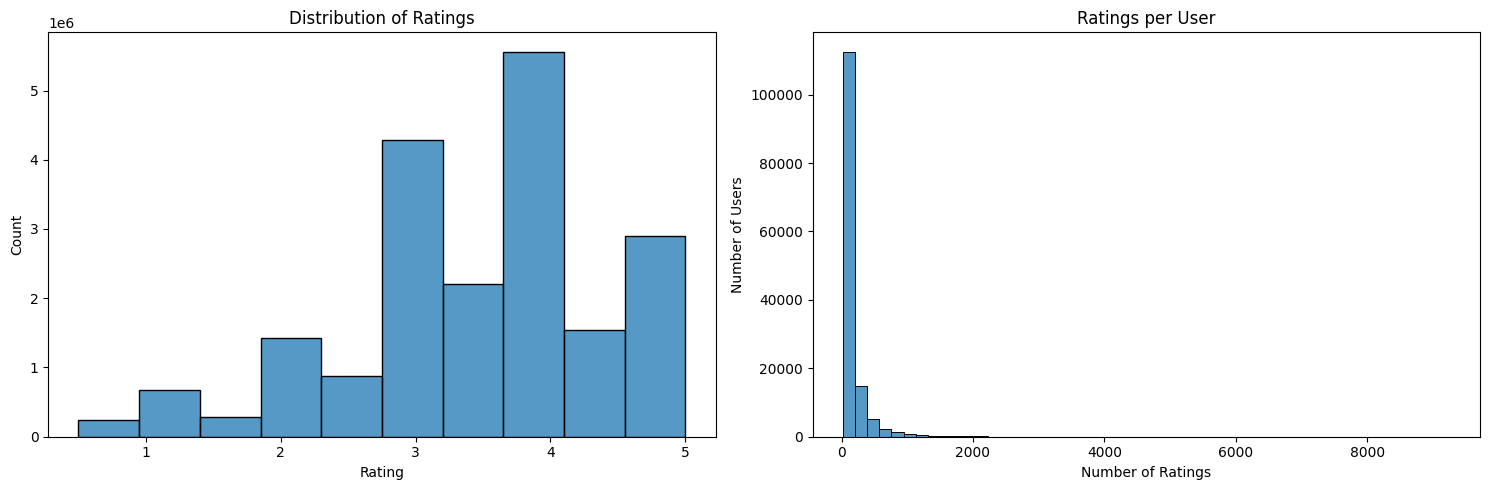


Ratings Summary Statistics:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: count, dtype: float64

Filtering movies...

Sampling 10000 users...

Creating user and movie mappings...

Dataset statistics after preprocessing:
Number of users: 10000
Number of movies: 10509
Number of ratings: 1451368
Sparsity: 98.62%

Analyzing processed rating distribution...


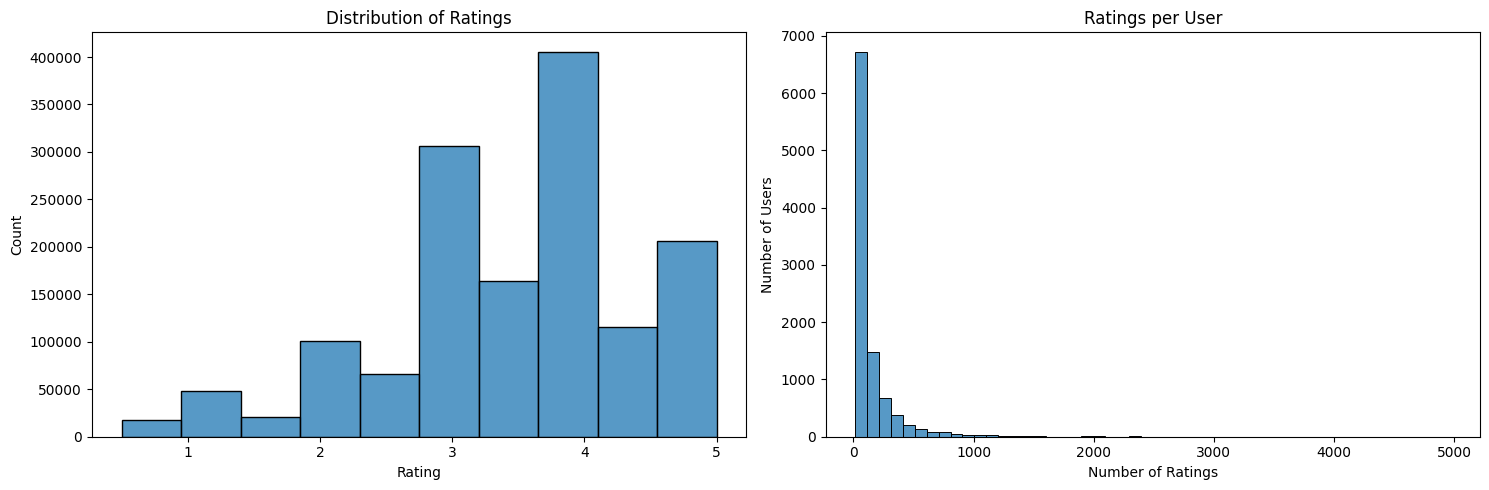


Ratings Summary Statistics:
count    1.451368e+06
mean     3.529136e+00
std      1.048826e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

User Activity Summary Statistics:
count    10000.000000
mean       145.136800
std        229.380897
min         16.000000
25%         34.000000
50%         67.000000
75%        153.000000
max       4968.000000
Name: count, dtype: float64

Generating rating heatmap (sample)...


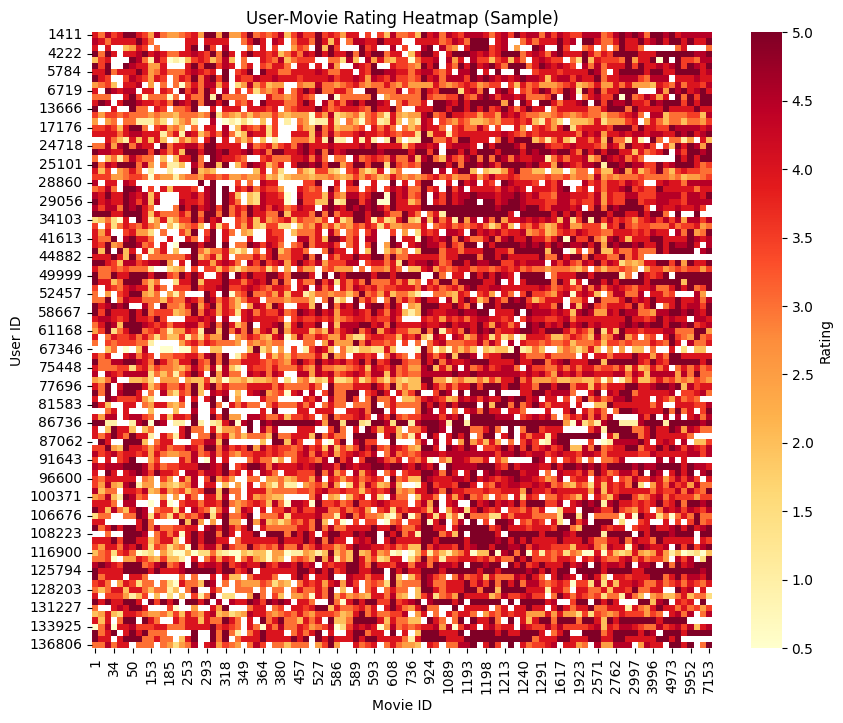


Movie genre distribution:
Drama        5150
Comedy       3767
Thriller     1996
Romance      1797
Action       1719
Crime        1277
Adventure    1189
Horror       1037
Sci-Fi        901
Fantasy       706
Name: count, dtype: int64

Splitting data...

Training model...
Creating sparse matrix...
Matrix creation took 0.07 seconds
Matrix shape: (10000, 10509)
Starting SVD...
SVD completed!

Evaluating model...
Test RMSE: 1.5691
Test MAE: 1.2511
Number of users: 10000
Number of movies: 10509
Training samples: 1015957
Validation samples: 217705
Test samples: 217706
Training NCF model on cpu
Epoch 5/20
Training Loss: 0.5800
Validation Loss: 0.5855
Epoch 10/20
Training Loss: 0.5670
Validation Loss: 0.5862
Epoch 15/20
Training Loss: 0.5587
Validation Loss: 0.5886
Epoch 20/20
Training Loss: 0.5533
Validation Loss: 0.5894

Neural CF Model Evaluation:
RMSE: 0.8440
MAE: 0.6394


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    try:
        # Get data
        model, filtered_ratings, filtered_movies, user_to_idx, movie_to_idx = main()

        # Create datasets
        train_df, temp_df = train_test_split(filtered_ratings, test_size=0.3, random_state=42)
        valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

        # Create data loaders
        batch_size = 256
        train_dataset = NCFDataset(train_df, len(user_to_idx), len(movie_to_idx))
        valid_dataset = NCFDataset(valid_df, len(user_to_idx), len(movie_to_idx))
        test_dataset = NCFDataset(test_df, len(user_to_idx), len(movie_to_idx))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Print dataset information
        print(f"Number of users: {len(user_to_idx)}")
        print(f"Number of movies: {len(movie_to_idx)}")
        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(valid_dataset)}")
        print(f"Test samples: {len(test_dataset)}")

        # Create and train model
        ncf_model = NeuralCollaborativeFiltering(
            n_users=len(user_to_idx),
            n_items=len(movie_to_idx),
            embedding_dim=64,
            layers=[128, 64, 32, 16]
        )

        # Train model
        trained_model = train_ncf_model(
            ncf_model,
            train_loader,
            valid_loader,
            n_epochs=20,
            learning_rate=0.001
        )

        # Evaluate model
        rmse, mae = evaluate_ncf_model(
            trained_model,
            test_loader,
            ratings_min=filtered_ratings['rating'].min(),
            ratings_max=filtered_ratings['rating'].max()
        )

    except Exception as e:
        print(f"Error training NCF model: {str(e)}")
        raise